## Save umaps to the original space

Just gonna do SSN_Ens and SSN_Ens Mean with the CVD dataset.

### Load in the resampled flair, and the uncertainty maps

In [1]:
import torch

In [2]:
# data
print("strawberry")
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
import SimpleITK as sitk
import nibabel as nib
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img
print("banana")

strawberry
banana


#### loading the uncertainty maps

In [3]:
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [4]:
# model_name = "SSN_Ens_Mean"
model_name = "SSN_Ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.05it/s]


In [5]:
key_order

['ent', 'pred', 'seg', 'var']

#### loading the preprocessed data in the resampled space

In [6]:
preproc_folder_path = "/home/s2208943/ipdis/data/preprocessed_data/EdData/"
domains_storage_name = ["domainA", "domainB", "domainC", "domainD"] # the name of the domain in the filesystem

filepaths_flair = []
filepaths_mask = []
for domain in domains_storage_name:
    imgs_folder = preproc_folder_path + domain + "/imgs/"
    filepaths_flair.extend([imgs_folder + f for f in os.listdir(imgs_folder) if "FLAIR.nii.gz" in f and "BET" not in f and "NORMALIZE" not in f])
    filepaths_mask.extend([imgs_folder + f for f in os.listdir(imgs_folder) if "FLAIR_BET_mask.nii.gz" in f])

In [7]:
filepaths_mask_map = {f.split("/")[-1].split("_")[0]:f for f in filepaths_mask}
filepaths_flair_map = {f.split("/")[-1].split("_")[0]:f for f in filepaths_flair}

In [8]:
def load_file(fp):
    return sitk.GetArrayFromImage(
        sitk.ReadImage(fp)
    ).astype(np.float32)

In [9]:
def load_flair_and_mask(key):
    return load_file(filepaths_flair_map[key]), load_file(filepaths_mask_map[key])

In [11]:
umap_names = list(output_maps_for_umaps.keys())
# for i in range(0, 200):
# umap_name = umap_names[i]
umap_name = "CVD103_out_maps"
umap_id = umap_name.split("_")[0]

flair, mask = load_flair_and_mask(umap_id)

umap = output_maps_for_umaps[umap_name][0]

# print(umap.shape, flair.shape, i)

# if umap.shape[0] != flair.shape[0]:
#     break

In [12]:
umap.shape, flair.shape, mask.shape

(torch.Size([56, 224, 160]), (56, 240, 240), (56, 240, 240))

### pad the height and width back to the right space

In [13]:
def pad_height_and_width(umap, flair_resampled):
    umap_shape = umap.shape
    flair_resampled_shape = flair_resampled.shape
    
    pad = ((flair_resampled_shape[1] - umap_shape[1]) // 2, (flair_resampled_shape[2] - umap_shape[2]) // 2)
    umap = torch.nn.functional.pad(umap, pad=(pad[1], pad[1], pad[0], pad[0]), mode='constant', value=0)
    
    assert umap.shape[1] == flair_resampled_shape[1]
    assert umap.shape[2] == flair_resampled_shape[2]
    
    return umap

In [14]:
umap = pad_height_and_width(umap, flair)
print(umap.shape, flair.shape)

torch.Size([56, 240, 240]) (56, 240, 240)


### pad the channel dimension if it doesn't match properly

In [15]:
def channel_pad(umap, flair_resampled):
    if umap.shape[0] == flair_resampled.shape[0]:
        return umap
    
    # the policy that was used was umap shape is equivalent to flair[start:start+centre_cut]
    # where start (is equivalent to) = (flair_resampled.shape[0] - umap.shape[0]) // 2
    
    # so padding at the beginning is start
    # and padding at the end is flair_resampled.shape[0] - umap.shape[0] - start
    
    padding_beginning = (flair_resampled.shape[0] - umap.shape[0]) // 2
    
    zeros = torch.zeros(flair_resampled.shape, dtype=umap.dtype)
    zeros[padding_beginning:padding_beginning+umap.shape[0]] = umap
    umap = zeros
    
    return umap

In [16]:
umap = channel_pad(umap, flair)

In [17]:
umap.shape, flair.shape

(torch.Size([56, 240, 240]), (56, 240, 240))

### set uncertainty to zero outside the mask

In [18]:
def zero_outside_mask(img, mask):
    img = img * torch.tensor(mask)
    return img

In [19]:
umap = zero_outside_mask(umap, mask)

### check that all the channels match up correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


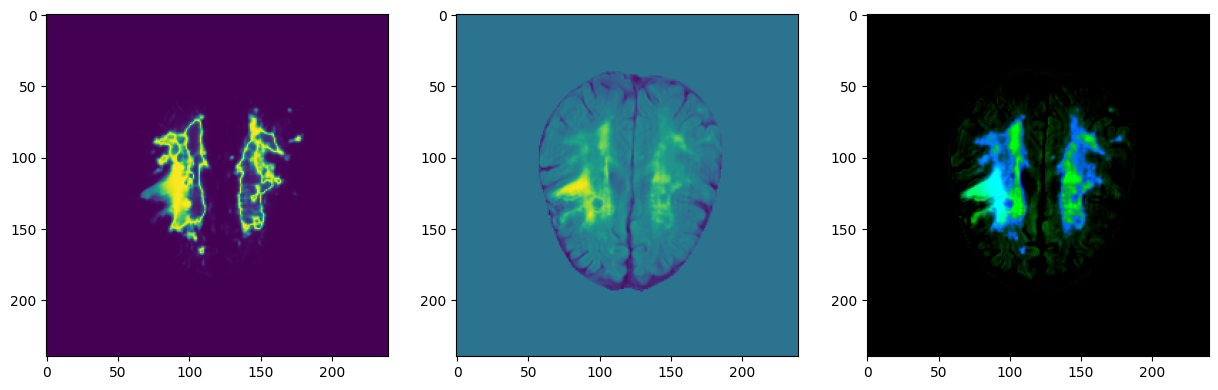

In [20]:
plt.figure(figsize=(15, 10))
islice=36
plt.subplot(1,3,1)
plt.imshow(umap[islice])
plt.subplot(1,3,2)
plt.imshow(flair[islice])
plt.subplot(1,3,3)
zeros = torch.zeros(umap.shape[1], umap.shape[2], 3)
zeros[:,:,1] = torch.tensor(flair[islice]) / 3
zeros[:,:,2] = umap[islice] / umap.max()
plt.imshow(zeros)

### convert image to nifti and set header to hold the correct space

In [21]:
def convert_torch_to_nifti(img, spacing=(1.,1.,3.)):
    nifti_img = sitk.GetImageFromArray(img.numpy())
    nifti_img.SetSpacing(spacing)
    
    return nifti_img

In [22]:
umap_nifti = convert_torch_to_nifti(umap)

In [23]:
umap.shape, flair.shape

(torch.Size([56, 240, 240]), (56, 240, 240))

### loading original image to find out it's spacing and shape

In [24]:
orig_folder = "/home/s2208943/ipdis/data/core_data/EdData/"

In [25]:
def load_orig_image(img_id):
    fp = orig_folder + img_id + "/MRI/FLAIR.nii.gz"
    return sitk.ReadImage(fp)

In [26]:
orig_flair = load_orig_image(umap_id)

In [27]:
orig_flair.GetSpacing()

(0.9375, 0.9375, 4.0)

### resample the nifti umap back to the space of the original flair

it is ***very important*** that is_label is on, otherwise the resampling process yields values that are incorrect (outside the 0 to max ent range that the umap is constrained to)

In [28]:
resampled_umap_nifti = get_resampled_img(umap_nifti, out_spacing=orig_flair.GetSpacing(), original_spacing=umap_nifti.GetSpacing(), is_label=True)

original spacing:  (1.0, 1.0, 3.0)


In [29]:
help(get_resampled_img)

Help on function get_resampled_img in module twaidata.MRI_preprep.resample:

get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1.0, 1.0, 3.0], is_label=False)
    # resamples an image



In [30]:
resampled_umap = torch.tensor(sitk.GetArrayFromImage(resampled_umap_nifti).astype(np.float32))

In [31]:
resampled_umap.shape

torch.Size([42, 256, 256])

### multiply by the mask in the original space to deal with resampling errors

In [32]:
def load_orig_mask(img_id):
    fp = orig_folder + img_id + "/masks/ICV.nii.gz"
    return sitk.GetArrayFromImage(sitk.ReadImage(fp)).astype(np.float32)

In [33]:
# orig_mask = load_orig_mask(umap_id)

In [34]:
# plt.imshow(orig_mask[29])

In [35]:
def multiply_by_orig_mask(resampled_umap, img_id):
    orig_mask = load_orig_mask(umap_id)
    resampled_umap = resampled_umap * torch.tensor(orig_mask)
    return resampled_umap

In [36]:
resampled_umap = multiply_by_orig_mask(resampled_umap, umap_id)

### check that the resampled image maps up correctly

In [37]:
resampled_umap.shape

torch.Size([42, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


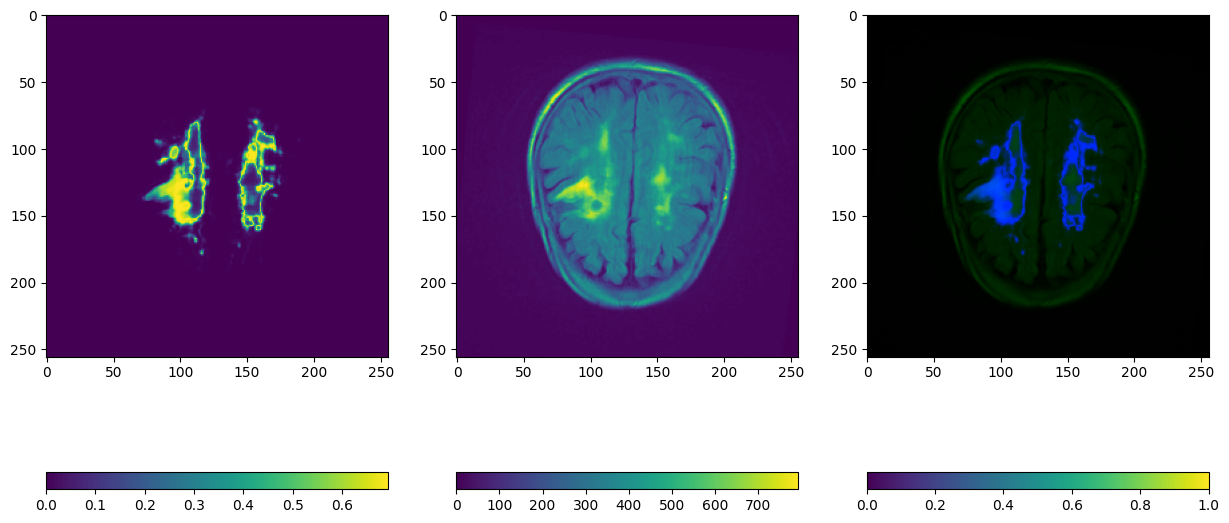

In [38]:
plt.figure(figsize=(15, 10))
islice=28
orig_flair_numpy = sitk.GetArrayFromImage(orig_flair)
plt.subplot(1,3,1)
plt.imshow(resampled_umap[islice]); plt.colorbar(location="bottom")
plt.subplot(1,3,2)
plt.imshow(orig_flair_numpy[islice]); plt.colorbar(location="bottom")
plt.subplot(1,3,3)
zeros = torch.zeros(resampled_umap.shape[1], resampled_umap.shape[2], 3)
zeros[:,:,1] = torch.tensor(orig_flair_numpy[islice]) / 2500
zeros[:,:,2] = resampled_umap[islice] / 0.69
plt.imshow(zeros); plt.colorbar(location="bottom")

In [39]:
assert orig_flair_numpy.shape[0] == resampled_umap.shape[0]
assert orig_flair_numpy.shape[1] == resampled_umap.shape[1]
assert orig_flair_numpy.shape[2] == resampled_umap.shape[2]

### convert the resampled image to int16 (skipped now)

In [40]:
# umap.max(), resampled_umap.max(), -torch.log(torch.tensor(1/2)).item(), umap.max() / -torch.log(torch.tensor(1/2)).item()

In [41]:
# ent_max = -torch.log(torch.tensor(1/2)).item()
# resampled_umap = resampled_umap / ent_max
# resampled_umap = resampled_umap * 32767

In [42]:
# resampled_umap_inty = resampled_umap.type(torch.int32)

In [43]:
# plt.imshow(resampled_umap_inty[27]); plt.colorbar()

### save the file, along with the correct header

In [44]:
umap_id

'CVD103'

In [45]:
def convert_dtype_and_save(resampled_umap, orig_flair, umap_id, save_location="/home/s2208943/ipdis/data/preprocessed_data/orig_space_EdData_umaps/SSN_Ens/"):
    # convert to int16
    ent_max = -torch.log(torch.tensor(1/2)).item()
    resampled_umap = resampled_umap / ent_max
    # resampled_umap = resampled_umap * 32767
    # resampled_umap_inty = resampled_umap
    # resampled_umap = resampled_umap.type(torch.int32)
    resampled_umap = resampled_umap.numpy()
    new_img = sitk.GetImageFromArray(resampled_umap)

    new_img.SetDirection(orig_flair.GetDirection())
    #print(new_img.GetSpacing())

    
    save_path = f"{save_location}{umap_id}_umap.nii.gz"
    sitk.WriteImage(new_img, save_path)

    # adjust the nifti file fields
    nib_flair = nib.load(orig_folder + umap_id + "/MRI/FLAIR.nii.gz")
    new_img = nib.load(save_path)
    new_img = nib.nifti1.Nifti1Image(new_img.dataobj[:], nib_flair.affine, nib_flair.header)
    
    # set the min and max values so that the uncertainty maps appear correctly in MRI-CRON.
    new_img.header['cal_max'] = 1#32767
    new_img.header['cal_min'] = 0
    new_img.set_data_dtype(np.float32) # the original flair is int16 but ive scaled my uncertainty 0-1.

    # the one line above does all of the below, and fixes pixdim4
    #new_img.header.set_xyzt_units(*flair.header.get_xyzt_units())
    # new_img.set_sform(flair.get_sform())
    # new_img.set_qform(flair.get_qform())

    nib.save(new_img, save_path)

In [46]:
convert_dtype_and_save(resampled_umap, orig_flair, umap_id, save_location="./")

In [47]:
result_umap = sitk.ReadImage("./CVD103_umap.nii.gz")

In [48]:
result_umap_arr = sitk.GetArrayFromImage(result_umap)

In [49]:
result_umap_arr.dtype

dtype('float32')

In [50]:
resampled_umap.max()

tensor(0.6931)

In [51]:
result_umap_arr.max()

1.0

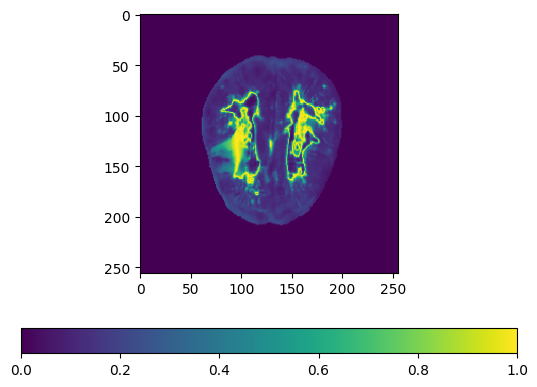

In [52]:
plt.imshow(result_umap_arr[26]); plt.colorbar(location='bottom')

### Putting the whole loop together

In [53]:
umap_names = list(output_maps_for_umaps.keys())
for i in tqdm(range(len(umap_names)), position=0, leave=True):
    try:
        umap_name = umap_names[i]
        umap_id = umap_name.split("_")[0]
        # if umap_name != "CVD103_out_maps":
        #     continue

        print(umap_id)

        # load the data in the resampled space
        flair, mask = load_flair_and_mask(umap_id)
        umap = output_maps_for_umaps[umap_name][0]


        # pad to make the slice size match
        umap = pad_height_and_width(umap, flair)
        umap = channel_pad(umap, flair)

        # set umap to zero outside mask
        umap = zero_outside_mask(umap, mask)

        # convert umap to nifti
        umap_nifti = convert_torch_to_nifti(umap)

        # load the original flair
        orig_flair = load_orig_image(umap_id)

        # resample the umap
        resampled_umap_nifti = get_resampled_img(umap_nifti, out_spacing=orig_flair.GetSpacing(), original_spacing=umap_nifti.GetSpacing(), is_label=True)
        resampled_umap = torch.tensor(sitk.GetArrayFromImage(resampled_umap_nifti).astype(np.float32))

        # make the resampled umap zero outside the original mask
        try:
            resampled_umap = multiply_by_orig_mask(resampled_umap, umap_id)
        except:
            print("no ICV available probably, skipping using the orginal space mask")

        # convert dtype to int16 and save the new umap
        convert_dtype_and_save(resampled_umap, orig_flair, umap_id)

    except:
        print("FAILED!!!!!! for ", umap_id)

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]

CVD152
original spacing:  (1.0, 1.0, 3.0)


  0%|▌                                                                                                                                                        | 1/250 [00:00<02:42,  1.53it/s]

CVD023
original spacing:  (1.0, 1.0, 3.0)


  1%|█▏                                                                                                                                                       | 2/250 [00:01<02:39,  1.56it/s]

CVD008
original spacing:  (1.0, 1.0, 3.0)


  1%|█▊                                                                                                                                                       | 3/250 [00:01<02:38,  1.56it/s]

CVD141
original spacing:  (1.0, 1.0, 3.0)


  2%|██▍                                                                                                                                                      | 4/250 [00:02<02:46,  1.47it/s]

CVD041
original spacing:  (1.0, 1.0, 3.0)


  2%|███                                                                                                                                                      | 5/250 [00:03<02:44,  1.49it/s]

CVD102
original spacing:  (1.0, 1.0, 3.0)


  2%|███▋                                                                                                                                                     | 6/250 [00:03<02:40,  1.52it/s]

CVD143
original spacing:  (1.0, 1.0, 3.0)


  3%|████▎                                                                                                                                                    | 7/250 [00:04<02:39,  1.52it/s]

CVD100
original spacing:  (1.0, 1.0, 3.0)


  3%|████▉                                                                                                                                                    | 8/250 [00:05<02:37,  1.54it/s]

CVD052
original spacing:  (1.0, 1.0, 3.0)


  4%|█████▌                                                                                                                                                   | 9/250 [00:05<02:34,  1.56it/s]

CVD188
original spacing:  (1.0, 1.0, 3.0)


  4%|██████                                                                                                                                                  | 10/250 [00:07<03:53,  1.03it/s]

CVD117
original spacing:  (1.0, 1.0, 3.0)


  4%|██████▋                                                                                                                                                 | 11/250 [00:09<04:45,  1.20s/it]

CVD065
original spacing:  (1.0, 1.0, 3.0)


  5%|███████▎                                                                                                                                                | 12/250 [00:11<05:24,  1.36s/it]

CVD075
original spacing:  (1.0, 1.0, 3.0)


  5%|███████▉                                                                                                                                                | 13/250 [00:12<06:03,  1.53s/it]

CVD158
original spacing:  (1.0, 1.0, 3.0)


  6%|████████▌                                                                                                                                               | 14/250 [00:15<07:29,  1.90s/it]

CVD206
original spacing:  (1.0, 1.0, 3.0)


  6%|█████████                                                                                                                                               | 15/250 [00:17<07:17,  1.86s/it]

CVD226
original spacing:  (1.0, 1.0, 3.0)


  6%|█████████▋                                                                                                                                              | 16/250 [00:18<06:37,  1.70s/it]

CVD013
original spacing:  (1.0, 1.0, 3.0)


  7%|██████████▎                                                                                                                                             | 17/250 [00:20<06:06,  1.58s/it]

CVD061
original spacing:  (1.0, 1.0, 3.0)


  7%|██████████▉                                                                                                                                             | 18/250 [00:21<05:49,  1.51s/it]

CVD146
original spacing:  (1.0, 1.0, 3.0)


  8%|███████████▌                                                                                                                                            | 19/250 [00:22<05:40,  1.48s/it]

CVD019
original spacing:  (1.0, 1.0, 3.0)


  8%|████████████▏                                                                                                                                           | 20/250 [00:24<05:33,  1.45s/it]

CVD043
original spacing:  (1.0, 1.0, 3.0)


  8%|████████████▊                                                                                                                                           | 21/250 [00:25<05:17,  1.39s/it]

CVD001
original spacing:  (1.0, 1.0, 3.0)


  9%|█████████████▍                                                                                                                                          | 22/250 [00:26<05:14,  1.38s/it]

CVD025
original spacing:  (1.0, 1.0, 3.0)


  9%|█████████████▉                                                                                                                                          | 23/250 [00:27<04:58,  1.32s/it]

CVD208
original spacing:  (1.0, 1.0, 3.0)


 10%|██████████████▌                                                                                                                                         | 24/250 [00:28<04:32,  1.21s/it]

CVD104
original spacing:  (1.0, 1.0, 3.0)


 10%|███████████████▏                                                                                                                                        | 25/250 [00:29<03:58,  1.06s/it]

CVD292
original spacing:  (1.0, 1.0, 3.0)


 10%|███████████████▊                                                                                                                                        | 26/250 [00:30<03:26,  1.09it/s]

CVD315
original spacing:  (1.0, 1.0, 3.0)


 11%|████████████████▍                                                                                                                                       | 27/250 [00:30<03:10,  1.17it/s]

CVD320
original spacing:  (1.0, 1.0, 3.0)


 11%|█████████████████                                                                                                                                       | 28/250 [00:31<03:01,  1.23it/s]

CVD271
original spacing:  (1.0, 1.0, 3.0)


 12%|█████████████████▋                                                                                                                                      | 29/250 [00:32<02:52,  1.28it/s]

CVD269
original spacing:  (1.0, 1.0, 3.0)


 12%|██████████████████▏                                                                                                                                     | 30/250 [00:33<02:45,  1.33it/s]

CVD126
original spacing:  (1.0, 1.0, 3.0)


 12%|██████████████████▊                                                                                                                                     | 31/250 [00:33<02:42,  1.35it/s]

CVD317
original spacing:  (1.0, 1.0, 3.0)


 13%|███████████████████▍                                                                                                                                    | 32/250 [00:34<02:37,  1.39it/s]

CVD277
original spacing:  (1.0, 1.0, 3.0)


 13%|████████████████████                                                                                                                                    | 33/250 [00:35<02:31,  1.43it/s]

CVD036
original spacing:  (1.0, 1.0, 3.0)


 14%|████████████████████▋                                                                                                                                   | 34/250 [00:35<02:32,  1.42it/s]

CVD257
original spacing:  (1.0, 1.0, 3.0)


 14%|█████████████████████▎                                                                                                                                  | 35/250 [00:36<02:33,  1.40it/s]

CVD278
original spacing:  (1.0, 1.0, 3.0)


 14%|█████████████████████▉                                                                                                                                  | 36/250 [00:37<02:34,  1.39it/s]

CVD049
original spacing:  (1.0, 1.0, 3.0)


 15%|██████████████████████▍                                                                                                                                 | 37/250 [00:38<02:36,  1.36it/s]

CVD266
original spacing:  (1.0, 1.0, 3.0)


 15%|███████████████████████                                                                                                                                 | 38/250 [00:38<02:32,  1.39it/s]

CVD273
original spacing:  (1.0, 1.0, 3.0)


 16%|███████████████████████▋                                                                                                                                | 39/250 [00:39<02:29,  1.41it/s]

CVD233
original spacing:  (1.0, 1.0, 3.0)


 16%|████████████████████████▎                                                                                                                               | 40/250 [00:40<02:30,  1.40it/s]

CVD089
original spacing:  (1.0, 1.0, 3.0)


 16%|████████████████████████▉                                                                                                                               | 41/250 [00:40<02:32,  1.37it/s]

CVD263
original spacing:  (1.0, 1.0, 3.0)


 17%|█████████████████████████▌                                                                                                                              | 42/250 [00:41<02:31,  1.38it/s]

CVD229
original spacing:  (1.0, 1.0, 3.0)


 17%|██████████████████████████▏                                                                                                                             | 43/250 [00:42<02:27,  1.41it/s]

CVD181
original spacing:  (1.0, 1.0, 3.0)


 18%|██████████████████████████▊                                                                                                                             | 44/250 [00:42<02:21,  1.46it/s]

CVD231
original spacing:  (1.0, 1.0, 3.0)


 18%|███████████████████████████▎                                                                                                                            | 45/250 [00:43<02:16,  1.50it/s]

CVD192
original spacing:  (1.0, 1.0, 3.0)


 18%|███████████████████████████▉                                                                                                                            | 46/250 [00:44<02:14,  1.52it/s]

CVD195
original spacing:  (1.0, 1.0, 3.0)


 19%|████████████████████████████▌                                                                                                                           | 47/250 [00:44<02:13,  1.52it/s]

CVD056
original spacing:  (1.0, 1.0, 3.0)


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [00:45<02:11,  1.53it/s]

CVD035
original spacing:  (1.0, 1.0, 3.0)


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [00:46<02:10,  1.54it/s]

CVD245
original spacing:  (1.0, 1.0, 3.0)


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [00:46<02:09,  1.55it/s]

CVD145
original spacing:  (1.0, 1.0, 3.0)


 20%|███████████████████████████████                                                                                                                         | 51/250 [00:47<02:04,  1.60it/s]

CVD078
original spacing:  (1.0, 1.0, 3.0)


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [00:48<02:55,  1.13it/s]

CVD073
original spacing:  (1.0, 1.0, 3.0)


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [00:50<03:30,  1.07s/it]

CVD004
original spacing:  (1.0, 1.0, 3.0)


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [00:51<03:57,  1.21s/it]

CVD127
original spacing:  (1.0, 1.0, 3.0)


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [00:53<04:16,  1.31s/it]

CVD121
original spacing:  (1.0, 1.0, 3.0)


 22%|██████████████████████████████████                                                                                                                      | 56/250 [00:54<04:26,  1.37s/it]

CVD133
original spacing:  (1.0, 1.0, 3.0)


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [00:56<04:12,  1.31s/it]

CVD063
original spacing:  (1.0, 1.0, 3.0)


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [00:57<04:01,  1.26s/it]

CVD137
original spacing:  (1.0, 1.0, 3.0)


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [00:58<03:52,  1.22s/it]

CVD028
original spacing:  (1.0, 1.0, 3.0)


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [00:59<03:52,  1.23s/it]

CVD204
original spacing:  (1.0, 1.0, 3.0)


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [01:00<03:41,  1.17s/it]

CVD178
original spacing:  (1.0, 1.0, 3.0)


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [01:01<03:35,  1.15s/it]

CVD148
original spacing:  (1.0, 1.0, 3.0)


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [01:02<03:31,  1.13s/it]

CVD038
original spacing:  (1.0, 1.0, 3.0)


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [01:04<03:32,  1.14s/it]

CVD151
original spacing:  (1.0, 1.0, 3.0)


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [01:05<03:23,  1.10s/it]

CVD205
original spacing:  (1.0, 1.0, 3.0)


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [01:05<03:08,  1.02s/it]

CVD156
original spacing:  (1.0, 1.0, 3.0)


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [01:06<02:51,  1.07it/s]

CVD250
original spacing:  (1.0, 1.0, 3.0)


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [01:07<02:34,  1.18it/s]

CVD313
original spacing:  (1.0, 1.0, 3.0)


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [01:07<02:24,  1.25it/s]

CVD153
original spacing:  (1.0, 1.0, 3.0)


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [01:08<02:21,  1.27it/s]

CVD264
original spacing:  (1.0, 1.0, 3.0)


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [01:09<02:16,  1.31it/s]

CVD249
original spacing:  (1.0, 1.0, 3.0)


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [01:10<02:12,  1.34it/s]

CVD316
original spacing:  (1.0, 1.0, 3.0)


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [01:10<02:09,  1.37it/s]

CVD275
original spacing:  (1.0, 1.0, 3.0)


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [01:11<02:08,  1.37it/s]

CVD045
original spacing:  (1.0, 1.0, 3.0)


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [01:12<02:10,  1.35it/s]

CVD242
original spacing:  (1.0, 1.0, 3.0)


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [01:13<02:08,  1.35it/s]

CVD252
original spacing:  (1.0, 1.0, 3.0)


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [01:13<02:06,  1.36it/s]

CVD324
original spacing:  (1.0, 1.0, 3.0)


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [01:14<02:05,  1.37it/s]

CVD267
original spacing:  (1.0, 1.0, 3.0)


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [01:15<02:01,  1.41it/s]

CVD130
original spacing:  (1.0, 1.0, 3.0)


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [01:15<02:02,  1.38it/s]

CVD009
original spacing:  (1.0, 1.0, 3.0)


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [01:16<02:03,  1.37it/s]

CVD294
original spacing:  (1.0, 1.0, 3.0)


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [01:17<02:04,  1.35it/s]

CVD194
original spacing:  (1.0, 1.0, 3.0)


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [01:18<02:05,  1.33it/s]

CVD285
original spacing:  (1.0, 1.0, 3.0)


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [01:18<01:58,  1.40it/s]

CVD175
original spacing:  (1.0, 1.0, 3.0)


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [01:19<01:54,  1.45it/s]

CVD118
original spacing:  (1.0, 1.0, 3.0)


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [01:20<01:51,  1.47it/s]

CVD170
original spacing:  (1.0, 1.0, 3.0)


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [01:20<01:46,  1.52it/s]

CVD098
original spacing:  (1.0, 1.0, 3.0)


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [01:21<01:47,  1.51it/s]

CVD081
original spacing:  (1.0, 1.0, 3.0)


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [01:21<01:43,  1.55it/s]

CVD173
original spacing:  (1.0, 1.0, 3.0)


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [01:22<01:43,  1.55it/s]

CVD084
original spacing:  (1.0, 1.0, 3.0)


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [01:23<01:42,  1.54it/s]

CVD077
original spacing:  (1.0, 1.0, 3.0)


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [01:23<01:42,  1.54it/s]

CVD247
original spacing:  (1.0, 1.0, 3.0)


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [01:24<01:42,  1.53it/s]

CVD172
original spacing:  (1.0, 1.0, 3.0)


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [01:26<02:22,  1.10it/s]

CVD124
original spacing:  (1.0, 1.0, 3.0)


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [01:27<02:48,  1.09s/it]

CVD030
original spacing:  (1.0, 1.0, 3.0)


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [01:29<03:04,  1.20s/it]

CVD083
original spacing:  (1.0, 1.0, 3.0)


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [01:30<03:18,  1.29s/it]

CVD216
original spacing:  (1.0, 1.0, 3.0)


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [01:32<03:26,  1.36s/it]

CVD114
original spacing:  (1.0, 1.0, 3.0)


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [01:33<03:14,  1.29s/it]

CVD032
original spacing:  (1.0, 1.0, 3.0)


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [01:34<03:02,  1.22s/it]

CVD240
original spacing:  (1.0, 1.0, 3.0)


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [01:35<02:58,  1.20s/it]

CVD183
original spacing:  (1.0, 1.0, 3.0)


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [01:36<02:51,  1.16s/it]

CVD003
original spacing:  (1.0, 1.0, 3.0)


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [01:37<02:39,  1.09s/it]

CVD080
original spacing:  (1.0, 1.0, 3.0)


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [01:38<02:38,  1.08s/it]

CVD202
original spacing:  (1.0, 1.0, 3.0)


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [01:39<02:29,  1.03s/it]

CVD155
original spacing:  (1.0, 1.0, 3.0)


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [01:40<02:27,  1.03s/it]

CVD060
original spacing:  (1.0, 1.0, 3.0)


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [01:41<02:26,  1.02s/it]

CVD107
original spacing:  (1.0, 1.0, 3.0)


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [01:42<02:18,  1.02it/s]

CVD299
original spacing:  (1.0, 1.0, 3.0)


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [01:42<02:05,  1.13it/s]

CVD230
original spacing:  (1.0, 1.0, 3.0)


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [01:43<01:59,  1.17it/s]

CVD167
original spacing:  (1.0, 1.0, 3.0)


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [01:44<01:54,  1.22it/s]

CVD310
original spacing:  (1.0, 1.0, 3.0)
no ICV available probably, skipping using the orginal space mask


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [01:45<01:56,  1.19it/s]

CVD286
original spacing:  (1.0, 1.0, 3.0)


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [01:46<01:49,  1.25it/s]

CVD298
original spacing:  (1.0, 1.0, 3.0)


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [01:46<01:43,  1.32it/s]

CVD290
original spacing:  (1.0, 1.0, 3.0)


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [01:47<01:41,  1.32it/s]

CVD258
original spacing:  (1.0, 1.0, 3.0)


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [01:48<01:40,  1.34it/s]

CVD268
original spacing:  (1.0, 1.0, 3.0)


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [01:48<01:38,  1.35it/s]

CVD129
original spacing:  (1.0, 1.0, 3.0)


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [01:49<01:39,  1.32it/s]

CVD280
original spacing:  (1.0, 1.0, 3.0)


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [01:50<01:39,  1.32it/s]

CVD174
original spacing:  (1.0, 1.0, 3.0)


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [01:51<01:37,  1.33it/s]

CVD306
original spacing:  (1.0, 1.0, 3.0)


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [01:51<01:34,  1.36it/s]

CVD261
original spacing:  (1.0, 1.0, 3.0)


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [01:52<01:33,  1.37it/s]

CVD284
original spacing:  (1.0, 1.0, 3.0)


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [01:53<01:32,  1.37it/s]

CVD287
original spacing:  (1.0, 1.0, 3.0)


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [01:54<01:33,  1.35it/s]

CVD239
original spacing:  (1.0, 1.0, 3.0)


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [01:54<01:33,  1.34it/s]

CVD254
original spacing:  (1.0, 1.0, 3.0)


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [01:55<01:31,  1.36it/s]

CVD179
original spacing:  (1.0, 1.0, 3.0)


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [01:56<01:27,  1.40it/s]

CVD128
original spacing:  (1.0, 1.0, 3.0)


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [01:56<01:24,  1.44it/s]

CVD024
original spacing:  (1.0, 1.0, 3.0)


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [01:57<01:22,  1.47it/s]

CVD085
original spacing:  (1.0, 1.0, 3.0)


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [01:58<01:22,  1.46it/s]

CVD016
original spacing:  (1.0, 1.0, 3.0)


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [01:58<01:22,  1.45it/s]

CVD134
original spacing:  (1.0, 1.0, 3.0)


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [01:59<01:20,  1.46it/s]

CVD225
original spacing:  (1.0, 1.0, 3.0)


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [02:00<01:19,  1.48it/s]

CVD079
original spacing:  (1.0, 1.0, 3.0)


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [02:00<01:17,  1.50it/s]

CVD105
original spacing:  (1.0, 1.0, 3.0)


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [02:01<01:15,  1.52it/s]

CVD112
original spacing:  (1.0, 1.0, 3.0)


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [02:03<01:44,  1.09it/s]

CVD238
original spacing:  (1.0, 1.0, 3.0)


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [02:04<02:04,  1.10s/it]

CVD111
original spacing:  (1.0, 1.0, 3.0)


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [02:06<02:18,  1.23s/it]

CVD031
original spacing:  (1.0, 1.0, 3.0)


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [02:07<02:26,  1.32s/it]

CVD166
original spacing:  (1.0, 1.0, 3.0)


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [02:09<02:32,  1.39s/it]

CVD040
original spacing:  (1.0, 1.0, 3.0)


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [02:10<02:25,  1.34s/it]

CVD234
original spacing:  (1.0, 1.0, 3.0)


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [02:11<02:20,  1.30s/it]

CVD042
original spacing:  (1.0, 1.0, 3.0)


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [02:13<02:22,  1.33s/it]

CVD241
original spacing:  (1.0, 1.0, 3.0)


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [02:14<02:14,  1.27s/it]

CVD091
original spacing:  (1.0, 1.0, 3.0)


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [02:15<02:19,  1.33s/it]

CVD017
original spacing:  (1.0, 1.0, 3.0)


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [02:16<02:17,  1.32s/it]

CVD140
original spacing:  (1.0, 1.0, 3.0)


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [02:18<02:16,  1.33s/it]

CVD097
original spacing:  (1.0, 1.0, 3.0)


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [02:22<03:31,  2.07s/it]

CVD213
original spacing:  (1.0, 1.0, 3.0)


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [02:23<03:04,  1.83s/it]

CVD039
original spacing:  (1.0, 1.0, 3.0)


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [02:24<02:45,  1.66s/it]

CVD050
original spacing:  (1.0, 1.0, 3.0)


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [02:25<02:26,  1.48s/it]

CVD272
original spacing:  (1.0, 1.0, 3.0)


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [02:26<02:10,  1.33s/it]

CVD086
original spacing:  (1.0, 1.0, 3.0)


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [02:27<01:58,  1.22s/it]

CVD309
original spacing:  (1.0, 1.0, 3.0)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [02:28<01:48,  1.13s/it]

CVD300
original spacing:  (1.0, 1.0, 3.0)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [02:29<01:45,  1.11s/it]

CVD253
original spacing:  (1.0, 1.0, 3.0)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [02:30<01:39,  1.06s/it]

CVD276
original spacing:  (1.0, 1.0, 3.0)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [02:31<01:35,  1.03s/it]

CVD282
original spacing:  (1.0, 1.0, 3.0)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [02:32<01:31,  1.00it/s]

CVD305
original spacing:  (1.0, 1.0, 3.0)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [02:33<01:30,  1.01it/s]

CVD314
original spacing:  (1.0, 1.0, 3.0)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [02:34<01:28,  1.02it/s]

CVD021
original spacing:  (1.0, 1.0, 3.0)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [02:35<01:27,  1.02it/s]

CVD303
original spacing:  (1.0, 1.0, 3.0)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [02:36<01:27,  1.00it/s]

CVD116
original spacing:  (1.0, 1.0, 3.0)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [02:37<01:27,  1.01s/it]

CVD106
original spacing:  (1.0, 1.0, 3.0)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [02:38<01:28,  1.02s/it]

CVD321
original spacing:  (1.0, 1.0, 3.0)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [02:39<01:26,  1.01s/it]

CVD295
original spacing:  (1.0, 1.0, 3.0)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [02:40<01:21,  1.03it/s]

CVD307
original spacing:  (1.0, 1.0, 3.0)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [02:41<01:20,  1.03it/s]

CVD169
original spacing:  (1.0, 1.0, 3.0)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [02:42<01:20,  1.02it/s]

CVD092
original spacing:  (1.0, 1.0, 3.0)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [02:43<01:18,  1.04it/s]

CVD237
original spacing:  (1.0, 1.0, 3.0)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [02:44<01:16,  1.05it/s]

CVD177
original spacing:  (1.0, 1.0, 3.0)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [02:45<01:15,  1.05it/s]

CVD088
original spacing:  (1.0, 1.0, 3.0)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [02:46<01:15,  1.04it/s]

CVD219
original spacing:  (1.0, 1.0, 3.0)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [02:47<01:11,  1.07it/s]

CVD090
original spacing:  (1.0, 1.0, 3.0)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [02:47<01:11,  1.06it/s]

CVD115
original spacing:  (1.0, 1.0, 3.0)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [02:48<01:09,  1.08it/s]

CVD161
original spacing:  (1.0, 1.0, 3.0)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [02:49<01:08,  1.08it/s]

CVD221
original spacing:  (1.0, 1.0, 3.0)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [02:50<01:08,  1.07it/s]

CVD108
original spacing:  (1.0, 1.0, 3.0)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [02:52<01:24,  1.17s/it]

CVD082
original spacing:  (1.0, 1.0, 3.0)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [02:54<01:37,  1.37s/it]

CVD012
original spacing:  (1.0, 1.0, 3.0)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [02:56<01:44,  1.49s/it]

CVD096
original spacing:  (1.0, 1.0, 3.0)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [02:57<01:48,  1.58s/it]

CVD191
original spacing:  (1.0, 1.0, 3.0)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [02:59<01:52,  1.65s/it]

CVD068
original spacing:  (1.0, 1.0, 3.0)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [03:01<01:46,  1.59s/it]

CVD055
original spacing:  (1.0, 1.0, 3.0)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [03:02<01:40,  1.53s/it]

CVD235
original spacing:  (1.0, 1.0, 3.0)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [03:03<01:37,  1.50s/it]

CVD150
original spacing:  (1.0, 1.0, 3.0)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [03:05<01:33,  1.45s/it]

CVD176
original spacing:  (1.0, 1.0, 3.0)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [03:06<01:29,  1.42s/it]

CVD047
original spacing:  (1.0, 1.0, 3.0)


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [03:07<01:26,  1.40s/it]

CVD220
original spacing:  (1.0, 1.0, 3.0)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [03:09<01:26,  1.42s/it]

CVD048
original spacing:  (1.0, 1.0, 3.0)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [03:10<01:24,  1.41s/it]

CVD203
original spacing:  (1.0, 1.0, 3.0)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [03:12<01:19,  1.34s/it]

CVD076
original spacing:  (1.0, 1.0, 3.0)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [03:13<01:16,  1.32s/it]

CVD020
original spacing:  (1.0, 1.0, 3.0)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [03:14<01:11,  1.26s/it]

CVD304
original spacing:  (1.0, 1.0, 3.0)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [03:15<01:05,  1.16s/it]

CVD308
original spacing:  (1.0, 1.0, 3.0)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [03:16<01:00,  1.10s/it]

CVD256
original spacing:  (1.0, 1.0, 3.0)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [03:17<00:57,  1.07s/it]

CVD325
original spacing:  (1.0, 1.0, 3.0)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [03:18<00:54,  1.02s/it]

CVD165
original spacing:  (1.0, 1.0, 3.0)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [03:19<00:53,  1.03s/it]

CVD236
original spacing:  (1.0, 1.0, 3.0)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [03:20<00:51,  1.01s/it]

CVD260
original spacing:  (1.0, 1.0, 3.0)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [03:21<00:49,  1.01it/s]

CVD171
original spacing:  (1.0, 1.0, 3.0)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [03:22<00:48,  1.02it/s]

CVD293
original spacing:  (1.0, 1.0, 3.0)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [03:23<00:45,  1.05it/s]

CVD288
original spacing:  (1.0, 1.0, 3.0)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [03:23<00:44,  1.06it/s]

CVD270
original spacing:  (1.0, 1.0, 3.0)


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [03:24<00:45,  1.02it/s]

CVD201
original spacing:  (1.0, 1.0, 3.0)


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [03:26<00:47,  1.05s/it]

CVD283
original spacing:  (1.0, 1.0, 3.0)
no ICV available probably, skipping using the orginal space mask


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [03:27<00:46,  1.06s/it]

CVD312
original spacing:  (1.0, 1.0, 3.0)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [03:28<00:45,  1.05s/it]

CVD248
original spacing:  (1.0, 1.0, 3.0)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [03:29<00:43,  1.03s/it]

CVD214
original spacing:  (1.0, 1.0, 3.0)


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [03:30<00:42,  1.03s/it]

CVD034
original spacing:  (1.0, 1.0, 3.0)


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [03:31<00:41,  1.03s/it]

CVD018
original spacing:  (1.0, 1.0, 3.0)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [03:32<00:38,  1.00it/s]

CVD074
original spacing:  (1.0, 1.0, 3.0)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [03:33<00:37,  1.01it/s]

CVD184
original spacing:  (1.0, 1.0, 3.0)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [03:34<00:35,  1.04it/s]

CVD113
original spacing:  (1.0, 1.0, 3.0)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [03:35<00:34,  1.05it/s]

CVD014
original spacing:  (1.0, 1.0, 3.0)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [03:35<00:32,  1.08it/s]

CVD064
original spacing:  (1.0, 1.0, 3.0)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [03:36<00:30,  1.10it/s]

CVD200
original spacing:  (1.0, 1.0, 3.0)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [03:38<00:33,  1.01s/it]

CVD138
original spacing:  (1.0, 1.0, 3.0)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [03:39<00:34,  1.07s/it]

CVD193
original spacing:  (1.0, 1.0, 3.0)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [03:40<00:36,  1.17s/it]

CVD011
original spacing:  (1.0, 1.0, 3.0)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [03:42<00:36,  1.22s/it]

CVD246
original spacing:  (1.0, 1.0, 3.0)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [03:43<00:37,  1.29s/it]

CVD207
original spacing:  (1.0, 1.0, 3.0)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [03:44<00:34,  1.24s/it]

CVD037
original spacing:  (1.0, 1.0, 3.0)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [03:45<00:32,  1.20s/it]

CVD157
original spacing:  (1.0, 1.0, 3.0)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [03:46<00:31,  1.19s/it]

CVD070
original spacing:  (1.0, 1.0, 3.0)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [03:48<00:31,  1.24s/it]

CVD002
original spacing:  (1.0, 1.0, 3.0)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [03:49<00:31,  1.30s/it]

CVD033
original spacing:  (1.0, 1.0, 3.0)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [03:51<00:30,  1.34s/it]

CVD218
original spacing:  (1.0, 1.0, 3.0)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [03:52<00:29,  1.35s/it]

CVD291
original spacing:  (1.0, 1.0, 3.0)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [03:53<00:26,  1.26s/it]

CVD265
original spacing:  (1.0, 1.0, 3.0)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [03:54<00:23,  1.19s/it]

CVD322
original spacing:  (1.0, 1.0, 3.0)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [03:55<00:21,  1.11s/it]

CVD274
original spacing:  (1.0, 1.0, 3.0)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [03:56<00:19,  1.06s/it]

CVD301
original spacing:  (1.0, 1.0, 3.0)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [03:57<00:18,  1.07s/it]

CVD297
original spacing:  (1.0, 1.0, 3.0)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [03:58<00:16,  1.05s/it]

CVD323
original spacing:  (1.0, 1.0, 3.0)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [03:59<00:15,  1.05s/it]

CVD251
original spacing:  (1.0, 1.0, 3.0)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [04:00<00:14,  1.04s/it]

CVD262
original spacing:  (1.0, 1.0, 3.0)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [04:01<00:13,  1.04s/it]

CVD255
original spacing:  (1.0, 1.0, 3.0)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [04:02<00:12,  1.03s/it]

CVD132
original spacing:  (1.0, 1.0, 3.0)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [04:03<00:11,  1.01s/it]

CVD319
original spacing:  (1.0, 1.0, 3.0)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [04:04<00:10,  1.02s/it]

CVD296
original spacing:  (1.0, 1.0, 3.0)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [04:05<00:09,  1.02s/it]

CVD186
original spacing:  (1.0, 1.0, 3.0)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [04:06<00:08,  1.03s/it]

CVD259
original spacing:  (1.0, 1.0, 3.0)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [04:07<00:07,  1.01s/it]

CVD311
original spacing:  (1.0, 1.0, 3.0)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [04:08<00:06,  1.01s/it]

CVD281
original spacing:  (1.0, 1.0, 3.0)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [04:09<00:05,  1.05s/it]

CVD289
original spacing:  (1.0, 1.0, 3.0)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [04:10<00:04,  1.01s/it]

CVD318
original spacing:  (1.0, 1.0, 3.0)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [04:11<00:02,  1.01it/s]

CVD302
original spacing:  (1.0, 1.0, 3.0)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [04:12<00:01,  1.01it/s]

CVD279
original spacing:  (1.0, 1.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [04:13<00:00,  1.04it/s]

CVD103
original spacing:  (1.0, 1.0, 3.0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:14<00:00,  1.02s/it]


### random other stuff being tested

In [54]:
import shutil

In [55]:
os.getcwd()

'/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code'

In [58]:
shutil.copy("/home/s2208943/ipdis/data/preprocessed_data/orig_space_EdData_umaps/SSN_Ens/CVD260_umap.nii.gz", ".")

'./CVD260_umap.nii.gz'

In [59]:

shutil.copy(orig_folder + "CVD260" + "/MRI/FLAIR.nii.gz", "./FLAIR_CVD260.nii.gz")

'./FLAIR_CVD260.nii.gz'

In [266]:
resampled_umap.unique()

tensor([0.0000e+00, 4.5537e-26, 2.4872e-25,  ..., 6.9314e-01, 6.9315e-01,
        6.9315e-01])

In [247]:
torch.where(resampled_umap < 0)

(tensor([ 2,  2,  2,  ..., 75, 75, 75]),
 tensor([ 89,  89,  89,  ..., 125, 125, 126]),
 tensor([126, 127, 128,  ..., 140, 142, 124]))

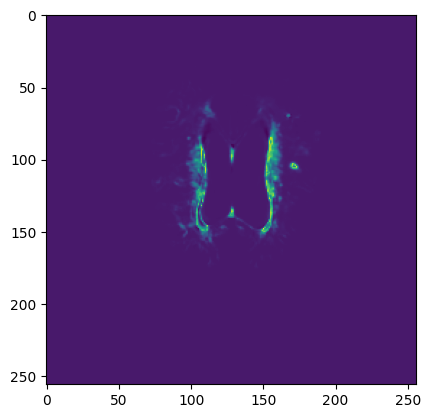

In [240]:
plt.imshow(resampled_umap[53])